In [1]:
import torch
import torchvision
import PIL
import os
from matplotlib import pyplot as plt
import cv2
import random
import warnings
import timm
from torch import nn
from tqdm import tqdm_notebook

warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')

Using: cuda


In [2]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src):
        self.src=src
        self.images=os.listdir(src)
        self.transforms=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                                       torchvision.transforms.Normalize((0.0,0.0,0.0),(1.0,1.0,1.0))])
    
    def __len__(self):
        return len(self.images)

    def apply_mosaic(self,image, top_left_x, top_left_y, width, height, mosaic_size):
        """
        Apply a mosaic effect to a specific area of the image.
    
        :param image: The original image.
        :param top_left_x: Top left x-coordinate of the mosaic area.
        :param top_left_y: Top left y-coordinate of the mosaic area.
        :param width: Width of the mosaic area.
        :param height: Height of the mosaic area.
        :param mosaic_size: Size of the mosaic blocks.
        """
        # Extract the region of interest
        roi = image[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
    
        #plt.imshow(roi)
        
        # Resize to mosaic size (downscale)
        roi_small = cv2.resize(roi, (mosaic_size, mosaic_size), interpolation=cv2.INTER_LINEAR)
    
        # Resize back to original size (upscale)
        mosaic = cv2.resize(roi_small, (width, height), interpolation=cv2.INTER_NEAREST)
        
        # Place the mosaic back into the original image
        image[top_left_y:top_left_y+height, top_left_x:top_left_x+width] = mosaic
        return image


    def __getitem__(self,idx):
        img=cv2.imread(self.src+"/"+self.images[idx])

        pixelize=random.randint(0,1)
        
        if(pixelize):           
            img_height, img_width = img.shape[:2]
    
            # Define the size of the mosaic area
            mosaic_width = random.randint(50,200)
            mosaic_height = random.randint(50,200)
            mosaic_size = random.randint(5,10)  # Size of each mosaic block
            
            # Randomly pick a spot
            top_left_x = random.randint(0, img_width - mosaic_width)
            top_left_y = random.randint(0, img_height - mosaic_height)
            
            # Apply the mosaic effect
            output_image = torch.from_numpy(self.apply_mosaic(img, top_left_x, top_left_y, mosaic_width, mosaic_height, mosaic_size)).permute(2,0,1)
    
            return self.transforms(output_image.type(torch.float32))/255, pixelize

        else:
            return self.transforms(torch.from_numpy(img).permute(2,0,1).type(torch.float32))/255, pixelize
        

In [3]:
train_ds=dataset("./temp/images/apple_pie/")
test_ds=dataset("./temp/images/baby_back_ribs/")

In [4]:
print(len(train_ds),len(test_ds))

1000 1000


torch.Size([3, 224, 224])
1


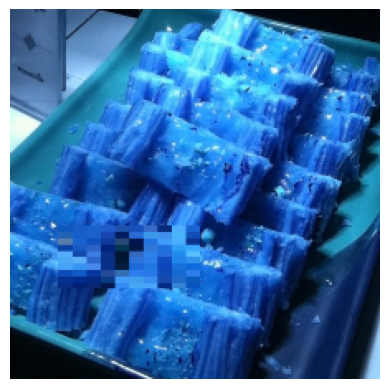

In [5]:
plt.axis(False)
t=train_ds.__getitem__(torch.randint(0,1000,(1,)))
print(t[0].shape)
plt.imshow(t[0].permute(1,2,0))
print(t[1])

In [6]:
train_loader=torch.utils.data.DataLoader(train_ds,16,shuffle=True)
val_loader=torch.utils.data.DataLoader(test_ds,16,shuffle=True)

In [7]:
timm.list_models('*mobilevit*',pretrained=True)

['mobilevit_s.cvnets_in1k',
 'mobilevit_xs.cvnets_in1k',
 'mobilevit_xxs.cvnets_in1k',
 'mobilevitv2_050.cvnets_in1k',
 'mobilevitv2_075.cvnets_in1k',
 'mobilevitv2_100.cvnets_in1k',
 'mobilevitv2_125.cvnets_in1k',
 'mobilevitv2_150.cvnets_in1k',
 'mobilevitv2_150.cvnets_in22k_ft_in1k',
 'mobilevitv2_150.cvnets_in22k_ft_in1k_384',
 'mobilevitv2_175.cvnets_in1k',
 'mobilevitv2_175.cvnets_in22k_ft_in1k',
 'mobilevitv2_175.cvnets_in22k_ft_in1k_384',
 'mobilevitv2_200.cvnets_in1k',
 'mobilevitv2_200.cvnets_in22k_ft_in1k',
 'mobilevitv2_200.cvnets_in22k_ft_in1k_384']

In [8]:
model=timm.create_model('mobilevitv2_200.cvnets_in22k_ft_in1k',pretrained=True,num_classes=1)

In [9]:
model.pretrained_cfg

{'url': '',
 'hf_hub_id': 'timm/mobilevitv2_200.cvnets_in22k_ft_in1k',
 'architecture': 'mobilevitv2_200',
 'tag': 'cvnets_in22k_ft_in1k',
 'custom_load': False,
 'input_size': (3, 256, 256),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.888,
 'crop_mode': 'center',
 'mean': (0.0, 0.0, 0.0),
 'std': (1.0, 1.0, 1.0),
 'num_classes': 1000,
 'pool_size': (8, 8),
 'first_conv': 'stem.conv',
 'classifier': 'head.fc'}

In [10]:
model

ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
          (bn): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=Tru

In [11]:
x,y=next(iter(train_loader))

In [12]:
output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
output

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
y

tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [14]:
loss_fn=nn.BCEWithLogitsLoss()

In [15]:
torch.squeeze(model(x),dim=1)

tensor([-0.1696,  0.0514, -0.1776, -0.0482,  0.3133, -0.0551, -0.2118,  0.1865,
         0.2000,  0.7423, -0.2706,  0.3189, -0.2946, -0.2033, -0.2729, -0.1210],
       grad_fn=<SqueezeBackward1>)

In [16]:
with torch.inference_mode():
    loss_fn(torch.squeeze(model(x),dim=1),y.type(torch.float32))

In [17]:
model=model.to(device)

In [18]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

def train_model(model,epochs):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.BCEWithLogitsLoss()
    
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        val_preds=torch.tensor([])
        train_actual=torch.tensor([])
        val_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and val data
        temp_train_accuracy=[]
        temp_val_accuracy=[]
        temp_train_loss=[]
        temp_val_loss=[]
        #temp_train_f1=[]
        #temp_val_f1=[]
    
        net_train_accuracy=0
        net_val_accuracy=0
        net_train_loss=0
        net_val_loss=0
        #net_train_f1=0
        #net_val_f1=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                    #f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    #temp_train_f1.append(f1_train.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        #net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        #writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        #writer.add_scalar("Train Loss",net_train_loss,i)
        #writer.add_scalar("Train F1 Score",net_train_f1,i)
    
        #Evaluation
        print("Testing:")
        model.eval()
    
        with tqdm_notebook(total=len(val_loader)) as pbar2:
            for x,y in val_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    val_preds=torch.hstack((val_preds,preds.to("cpu")))
                    val_actual=torch.hstack((val_actual,y.to("cpu")))
                    accuracy_val=accuracy_fn(logits,y)
                    #f1_val=f1_fn(preds,y)
                    temp_val_accuracy.append(accuracy_val)
                    temp_val_loss.append(loss.item())
                    #temp_val_f1.append(f1_val.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
        net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
        #net_val_f1=sum(temp_val_f1)/len(temp_val_f1)
        #writer.add_scalar("Val Accuracy",net_val_accuracy,i)
        #writer.add_scalar("Val Loss",net_val_loss,i)
        #writer.add_scalar("Val F1 Score",net_val_f1,i)

        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nVal Accuracy: {net_val_accuracy}\n\nVal Loss: {net_val_loss}")



In [19]:
train_model(model,10)

  0%|          | 0/10 [00:00<?, ?it/s]


Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1:

Train Accuracy: 0.5238095238095238

Train Loss: 0.36277604021043297

Val Accuracy: 0.4871031746031746

Val Loss: 0.982784529733989

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 0.4990079365079365

Train Loss: 0.2825617145539986

Val Accuracy: 0.48412698412698413

Val Loss: 1.3598503205511305

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
x,y=next(iter(val_loader))
x=x.to(device)
y=y.to(device)

In [21]:
output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
output

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacty of 5.80 GiB of which 32.81 MiB is free. Including non-PyTorch memory, this process has 5.75 GiB memory in use. Of the allocated memory 5.41 GiB is allocated by PyTorch, and 179.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
y

tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')